# Automated CapsnetsS2I train + test

First, import stuff

In [7]:
import model_s2i
import data_loader
import tensorflow as tf

In [8]:
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

## Load word vectors and data

In [23]:
WORD_VEC_SCENARIO = "FastText-300-verbsDatasets-synAntVSP-dia"
SCENARIO_NAME = 'balanced-s1-2'

word2vec_path = '../../romanian_word_vecs/cleaned-vectors-diacritice.vec'

# No diacritics data
training_data_paths = [
#         '../data-capsnets/scenario0/train.txt',
#         '../data-capsnets/scenario1/train.txt',
#         '../data-capsnets/scenario2/train.txt',
#         '../data-capsnets/scenario3.1/train.txt',
#         '../data-capsnets/scenario3.2/train.txt',
#         '../data-capsnets/scenario3.3/train.txt',
        '../data-capsnets/diacritics/scenario0/train.txt',
        '../data-capsnets/diacritics/scenario1/train.txt',
        '../data-capsnets/diacritics/scenario2/train.txt',
        '../data-capsnets/diacritics/scenario31/train.txt',
        '../data-capsnets/diacritics/scenario32/train.txt',
        '../data-capsnets/diacritics/scenario33/train.txt',
        
    ]
test_data_paths = [
#     '../data-capsnets/scenario0/test.txt',
#     '../data-capsnets/scenario1/test.txt',
#     '../data-capsnets/scenario2/test.txt',
#     '../data-capsnets/scenario3.1/test.txt',
#     '../data-capsnets/scenario3.2/test.txt',
#     '../data-capsnets/scenario3.3/test.txt',
    '../data-capsnets/diacritics/scenario0/test.txt',
    '../data-capsnets/diacritics/scenario1/test.txt',
    '../data-capsnets/diacritics/scenario2/test.txt',
    '../data-capsnets/diacritics/scenario31/test.txt',
    '../data-capsnets/diacritics/scenario32/test.txt',
    '../data-capsnets/diacritics/scenario33/test.txt',
]

scenario_nums = [
#     '0_' + WORD_VEC_SCENARIO,
#     '1_' + WORD_VEC_SCENARIO,
#     '2_' + WORD_VEC_SCENARIO,
#     '31_' + WORD_VEC_SCENARIO,
#     '32_' + WORD_VEC_SCENARIO,
#     '33_' + WORD_VEC_SCENARIO,
#     '0_dia_' + WORD_VEC_SCENARIO,
#     '1_dia_' + WORD_VEC_SCENARIO,
#     '2_dia_' + WORD_VEC_SCENARIO,
#     '31_dia_' + WORD_VEC_SCENARIO,
#     '32_dia_' + WORD_VEC_SCENARIO,
#     '33_dia_' + WORD_VEC_SCENARIO,
    '0-' + SCENARIO_NAME,
    '1-' + SCENARIO_NAME,
    '2-' + SCENARIO_NAME,
    '31-' + SCENARIO_NAME,
    '32-' + SCENARIO_NAME,
    '33-' + SCENARIO_NAME,
]

In [24]:
print('------------------load word2vec begin-------------------')
w2v = data_loader.load_w2v(word2vec_path)
print('------------------load word2vec end---------------------')

------------------load word2vec begin-------------------
loading time took 000.09
------------------load word2vec end---------------------


# Flag setting functions + utils

In [25]:
import csv

def set_flags(data, scenario):
    FLAGS = tf.app.flags.FLAGS

    tf.app.flags.DEFINE_boolean('save_model', False, 'save model to disk')
    tf.app.flags.DEFINE_string('summaries_dir', './logs', 'tensorboard summaries')
    tf.app.flags.DEFINE_string('ckpt_dir', './saved_models/', 'check point dir')
    tf.app.flags.DEFINE_string('scenario_num', scenario, 'Scenario number')
    tf.app.flags.DEFINE_string('errors_dir', './errors/', 'Errors dir')
    tf.app.flags.DEFINE_string('results_dir', './results/', 'Results dir')
    tf.app.flags.DEFINE_string('hyperparams_dir', './hyperparams/', 'Hyperparams dir')
    
    vocab_size, word_emb_size = data['embedding'].shape
    _, max_sentence_length = data['x_tr'].shape
    intents_number = len(data['intents_dict'])
    slots_number = len(data['slots_dict'])
    hidden_size = 64

    tf.app.flags.DEFINE_float('keep_prob', 1, 'embedding dropout keep rate for training')
    tf.app.flags.DEFINE_integer('hidden_size', hidden_size, 'embedding vector size')
    tf.app.flags.DEFINE_integer('batch_size', 32, 'batch size')
    tf.app.flags.DEFINE_integer('num_epochs', 20, 'num of epochs')
    tf.app.flags.DEFINE_integer('vocab_size', vocab_size, 'vocab size of word vectors')
    tf.app.flags.DEFINE_integer('max_sentence_length', max_sentence_length, 'max number of words in one sentence')
    tf.app.flags.DEFINE_integer('intents_nr', intents_number, 'intents_number')  #
    tf.app.flags.DEFINE_integer('slots_nr', slots_number, 'slots_number')  #
    tf.app.flags.DEFINE_integer('word_emb_size', word_emb_size, 'embedding size of word vectors')
    tf.app.flags.DEFINE_boolean('use_embedding', True, 'whether to use embedding or not.')
    tf.app.flags.DEFINE_float('learning_rate', 0.01, 'learning rate')
    tf.app.flags.DEFINE_integer('slot_routing_num', 2, 'slot routing num')
    tf.app.flags.DEFINE_integer('intent_routing_num', 3, 'intent routing num')
    tf.app.flags.DEFINE_integer('intent_output_dim', 16, 'intent output dimension')
    tf.app.flags.DEFINE_integer('slot_output_dim', 2 * hidden_size, 'slot output dimension')
    tf.app.flags.DEFINE_integer('d_a', 20, 'self attention weight hidden units number')
    tf.app.flags.DEFINE_integer('r', 3, 'number of self attention heads')
    tf.app.flags.DEFINE_float('alpha', 0.0001, 'coefficient for self attention loss')
    tf.app.flags.DEFINE_integer('n_splits', 3, 'Number of cross-validation splits')
    tf.app.flags.DEFINE_float('rerouting_coef', 0.5, 'coefficient for rerouting')
    tf.app.flags.DEFINE_boolean('use_rerouting', True, 'whether to use rerouting or not')
    tf.app.flags.DEFINE_boolean('use_attention', True,
                                'whether to use attention or not. If attention is used,'
                                'slot_output_dim will be overridden to hidden_size * 2')
    
    tf.app.flags.DEFINE_string('f', '', 'kernel') # Without this there's an error: unknown command line flag 'f'
    
    return FLAGS

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)
        
def write_csv(run_results):
    with open('results/results_{}.csv'.format(SCENARIO_NAME), 'w') as f:
        header_line = ['Scenario', 'Intent F1', 'Slot F1']
        writer = csv.writer(f)
        writer.writerow(header_line)
        for k, v in run_results.items():
            scenario_num = [k]
            intent_score = [v['intent_f1']]
            slot_score = [v['slot_f1']]
            l = scenario_num + intent_score + slot_score
            writer.writerow(l)

In [22]:
# In case it's needed
del_all_flags(FLAGS)

------------------read datasets begin-------------------
max length is 15
max length is 15
------------------read datasets end---------------------
TRAINING 0-balanced-s1-2
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.069048
F score 0.069048
Slot filling
F1 score: 0.022165
Accuracy: 0.021429
------------------epoch :  0  Loss:  8.4487095 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.642857
F score 0.642857
Slot filling
F1 score: 0.534694
Accuracy: 0.938095
Current F score mean 0.5887755102040817
Best F score mean 0.5887755102040817
------------------epoch :  1  Loss:  3.6874132 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.795238
F score 0.795238
Slot filling
F1 s

------------------epoch :  5  Loss:  0.005884333 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997619
F score 0.997619
Slot filling
F1 score: 0.972589
Accuracy: 0.997302
Current F score mean 0.9851039400531787
Best F score mean 0.9915090679856464
------------------epoch :  6  Loss:  0.005420481 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995238
F score 0.995238
Slot filling
F1 score: 0.974619
Accuracy: 0.997302
Current F score mean 0.9849286922890984
Best F score mean 0.9915090679856464
------------------epoch :  7  Loss:  0.0045063263 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997619
F score 0.997619
Slot filling
F1 score: 0.978637
Accuracy: 0.997619
Current F score mean 0.988127936830887
Best F score mean 0.9915090679856464
------------------epoch :  8  Loss:  0.0037800344 ----------------------
           V

------------------epoch :  11  Loss:  0.0038913102 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992857
F score 0.992857
Slot filling
F1 score: 0.994934
Accuracy: 0.999683
Current F score mean 0.9938956433637285
Best F score mean 0.9938956433637285
------------------epoch :  12  Loss:  0.0035774463 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992857
F score 0.992857
Slot filling
F1 score: 0.994934
Accuracy: 0.999683
Current F score mean 0.9938956433637285
Best F score mean 0.9938956433637285
------------------epoch :  13  Loss:  0.0033266996 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992857
F score 0.992857
Slot filling
F1 score: 0.994934
Accuracy: 0.999683
Current F score mean 0.9938956433637285
Best F score mean 0.9938956433637285
------------------epoch :  14  Loss:  0.0031206703 ----------------------
     

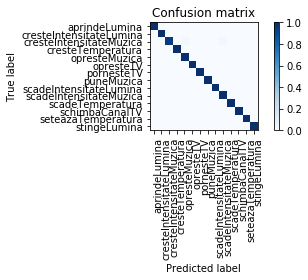

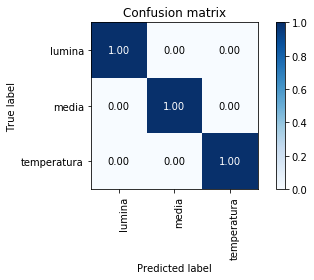

Intent F1: 0.996429
Slot F1: 0.987053
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 1-balanced-s1-2
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.076190
F score 0.076190
Slot filling
F1 score: 0.020841
Accuracy: 0.087245
------------------epoch :  0  Loss:  15.7645855 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.685714
F score 0.685714
Slot filling
F1 score: 0.412739
Accuracy: 0.923129
Current F score mean 0.5492265696087353
Best F score mean 0.5492265696087353
------------------epoch :  1  Loss:  4.9148293 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.96

Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  5  Loss:  0.010221241 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  6  Loss:  0.00688436 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  7  Loss:  0.0054724407 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  8  Loss:  0.004636619 ----------------------
           VALIDATION SET PERFORMANCE        
Intent det

------------------epoch :  13  Loss:  0.0022620503 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.990476
F score 0.990476
Slot filling
F1 score: 0.993952
Accuracy: 0.999490
Current F score mean 0.9922139016897081
Best F score mean 1.0
------------------epoch :  14  Loss:  0.0021280106 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.990476
F score 0.990476
Slot filling
F1 score: 0.996973
Accuracy: 0.999660
Current F score mean 0.9937244726346643
Best F score mean 1.0
------------------epoch :  15  Loss:  0.0020076158 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.990476
F score 0.990476
Slot filling
F1 score: 0.996973
Accuracy: 0.999660
Current F score mean 0.9937244726346643
Best F score mean 1.0
------------------epoch :  16  Loss:  0.0018986315 ----------------------
           VALIDATION SET PERFORMANCE        
Inte

<Figure size 432x288 with 0 Axes>

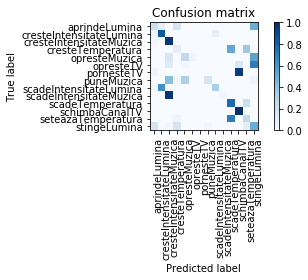

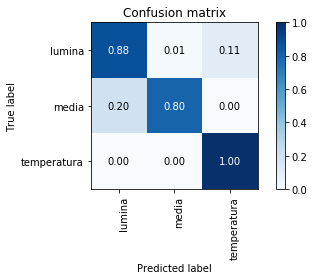

Intent F1: 0.389286
Slot F1: 0.783803
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 2-balanced-s1-2
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.083333
F score 0.083333
Slot filling
F1 score: 0.014304
Accuracy: 0.074603
------------------epoch :  0  Loss:  15.151252 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.708333
F score 0.708333
Slot filling
F1 score: 0.555975
Accuracy: 0.926190
Current F score mean 0.6321540880503145
Best F score mean 0.6321540880503145
------------------epoch :  1  Loss:  2.9940405 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.927

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994444
F score 0.994444
Slot filling
F1 score: 0.997959
Accuracy: 0.999603
Current F score mean 0.9962018140589569
Best F score mean 0.9989583333333333
------------------epoch :  5  Loss:  0.012093054 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.997959
Accuracy: 0.999603
Current F score mean 0.9989795918367347
Best F score mean 0.9989795918367347
------------------epoch :  6  Loss:  0.009630924 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.997959
Accuracy: 0.999603
Current F score mean 0.9989795918367347
Best F score mean 0.9989795918367347
------------------epoch :  7  Loss:  0.008118005 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.0000

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.994764
Accuracy: 0.999603
Current F score mean 0.9973821989528796
Best F score mean 0.9989795918367347
------------------epoch :  11  Loss:  0.0049123736 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.994764
Accuracy: 0.999603
Current F score mean 0.9973821989528796
Best F score mean 0.9989795918367347
------------------epoch :  12  Loss:  0.0046313526 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.994764
Accuracy: 0.999603
Current F score mean 0.9973821989528796
Best F score mean 0.9989795918367347
------------------epoch :  13  Loss:  0.0044045276 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 

<Figure size 432x288 with 0 Axes>

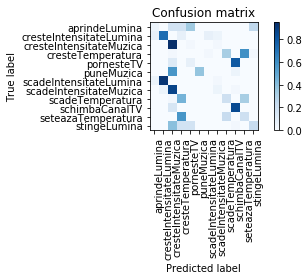

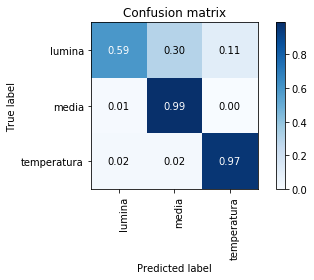

Intent F1: 0.308333
Slot F1: 0.533821
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 31-balanced-s1-2
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.009615
F score 0.009615
Slot filling
F1 score: 0.017131
Accuracy: 0.093178
------------------epoch :  0  Loss:  15.140918 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.756410
F score 0.756410
Slot filling
F1 score: 0.406534
Accuracy: 0.934295
Current F score mean 0.5814719158639304
Best F score mean 0.5814719158639304
------------------epoch :  1  Loss:  2.829871 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.945

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.980769
F score 0.980769
Slot filling
F1 score: 0.986466
Accuracy: 0.999084
Current F score mean 0.9836176980913822
Best F score mean 0.9859991555350837
------------------epoch :  5  Loss:  0.038447678 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.987179
F score 0.987179
Slot filling
F1 score: 0.990991
Accuracy: 0.999542
Current F score mean 0.9890852390852392
Best F score mean 0.9890852390852392
------------------epoch :  6  Loss:  0.0111762695 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.983974
F score 0.983974
Slot filling
F1 score: 0.984940
Accuracy: 0.998855
Current F score mean 0.9844570590052517
Best F score mean 0.9890852390852392
------------------epoch :  7  Loss:  0.0089256875 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.98

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.990385
F score 0.990385
Slot filling
F1 score: 0.987988
Accuracy: 0.998626
Current F score mean 0.9891863016863016
Best F score mean 0.9891863016863016
------------------epoch :  11  Loss:  0.005689021 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.990385
F score 0.990385
Slot filling
F1 score: 0.987988
Accuracy: 0.998626
Current F score mean 0.9891863016863016
Best F score mean 0.9891863016863016
------------------epoch :  12  Loss:  0.0052827927 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.990385
F score 0.990385
Slot filling
F1 score: 0.987988
Accuracy: 0.998626
Current F score mean 0.9891863016863016
Best F score mean 0.9891863016863016
------------------epoch :  13  Loss:  0.00497104 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.9

<Figure size 432x288 with 0 Axes>

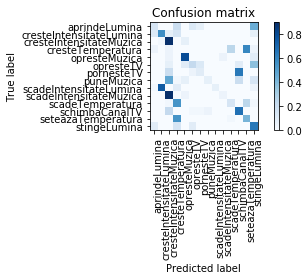

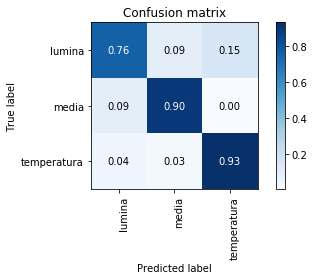

Intent F1: 0.346429
Slot F1: 0.452660
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 32-balanced-s1-2
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.008850
F score 0.008850
Slot filling
F1 score: 0.019914
Accuracy: 0.127897
------------------epoch :  0  Loss:  14.514619 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.687316
F score 0.687316
Slot filling
F1 score: 0.580645
Accuracy: 0.953224
Current F score mean 0.6339803977543059
Best F score mean 0.6339803977543059
------------------epoch :  1  Loss:  2.4119058 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.89

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.988201
F score 0.988201
Slot filling
F1 score: 0.954268
Accuracy: 0.995786
Current F score mean 0.9712344413267141
Best F score mean 0.9863444520081688
------------------epoch :  5  Loss:  0.03149219 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985251
F score 0.985251
Slot filling
F1 score: 0.961598
Accuracy: 0.996629
Current F score mean 0.9734241398529151
Best F score mean 0.9863444520081688
------------------epoch :  6  Loss:  0.014433825 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985251
F score 0.985251
Slot filling
F1 score: 0.954128
Accuracy: 0.996207
Current F score mean 0.9696895889150496
Best F score mean 0.9863444520081688
------------------epoch :  7  Loss:  0.006779845 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.98230

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.962631
Accuracy: 0.995786
Current F score mean 0.9813153961136024
Best F score mean 0.9863444520081688
------------------epoch :  11  Loss:  0.002729171 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.962631
Accuracy: 0.995786
Current F score mean 0.9813153961136024
Best F score mean 0.9863444520081688
------------------epoch :  12  Loss:  0.0025081655 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.962631
Accuracy: 0.995786
Current F score mean 0.9813153961136024
Best F score mean 0.9863444520081688
------------------epoch :  13  Loss:  0.0023321817 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1

<Figure size 432x288 with 0 Axes>

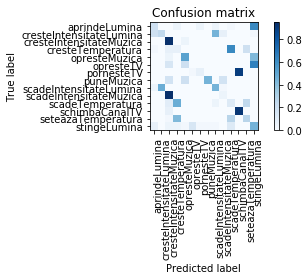

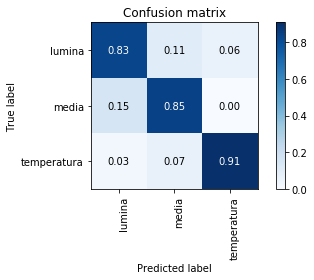

Intent F1: 0.342857
Slot F1: 0.482257
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 33-balanced-s1-2
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.129870
F score 0.129870
Slot filling
F1 score: 0.022203
Accuracy: 0.066481
------------------epoch :  0  Loss:  17.355896 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.562771
F score 0.562771
Slot filling
F1 score: 0.452941
Accuracy: 0.886518
Current F score mean 0.5078558696205755
Best F score mean 0.5078558696205755
------------------epoch :  1  Loss:  6.254239 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.783

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.935065
F score 0.935065
Slot filling
F1 score: 0.965517
Accuracy: 0.995362
Current F score mean 0.9502910882221227
Best F score mean 0.9928932178932179
------------------epoch :  5  Loss:  0.013299975 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.930736
F score 0.930736
Slot filling
F1 score: 0.964088
Accuracy: 0.995053
Current F score mean 0.9474121642629929
Best F score mean 0.9928932178932179
------------------epoch :  6  Loss:  0.008984867 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.961039
F score 0.961039
Slot filling
F1 score: 0.971114
Accuracy: 0.996599
Current F score mean 0.9660765644259455
Best F score mean 0.9928932178932179
------------------epoch :  7  Loss:  0.0063463207 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.965

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995671
F score 0.995671
Slot filling
F1 score: 0.975207
Accuracy: 0.996908
Current F score mean 0.9854388036206219
Best F score mean 0.9928932178932179
------------------epoch :  11  Loss:  0.0056885034 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995671
F score 0.995671
Slot filling
F1 score: 0.975207
Accuracy: 0.996908
Current F score mean 0.9854388036206219
Best F score mean 0.9928932178932179
------------------epoch :  12  Loss:  0.0052926587 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995671
F score 0.995671
Slot filling
F1 score: 0.975207
Accuracy: 0.996908
Current F score mean 0.9854388036206219
Best F score mean 0.9928932178932179
------------------epoch :  13  Loss:  0.0049827984 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 

<Figure size 432x288 with 0 Axes>

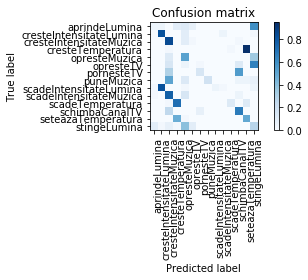

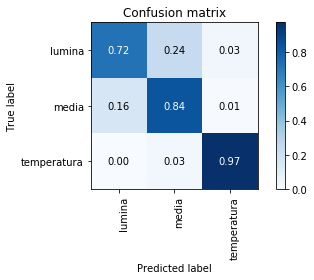

Intent F1: 0.300537
Slot F1: 0.491197


<Figure size 432x288 with 0 Axes>

In [26]:
import train
import test

results = dict()
for i in range(len(training_data_paths)):
    
    # Load data
    data = data_loader.read_datasets(w2v, training_data_paths[i], test_data_paths[i], test=True)
    
    FLAGS = set_flags(data, scenario=scenario_nums[i])
    
    # Train model
    print('TRAINING ' + scenario_nums[i])
    train.train(model_s2i.CapsNetS2I, data, FLAGS, batches_rand=False)
    
    # Test model
    print('TESTING ' + scenario_nums[i])
    intent_f, slot_f = test.test(model_s2i.CapsNetS2I, data, FLAGS)
    results[scenario_nums[i]] = dict()
    results[scenario_nums[i]]['intent_f1'] = intent_f
    results[scenario_nums[i]]['slot_f1'] = slot_f
        
    # Reset flags
    del_all_flags(FLAGS)

write_csv(results)